Notebook purpose: treate the 104 5D-SXDM dataset collected on InGaN.

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Initialisation" data-toc-modified-id="Initialisation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Initialisation</a></span></li><li><span><a href="#Data-inspection" data-toc-modified-id="Data-inspection-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data inspection</a></span></li><li><span><a href="#Correction-of-sample-drifts" data-toc-modified-id="Correction-of-sample-drifts-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correction of sample drifts</a></span></li><li><span><a href="#Transformation-from-angular-to-reciprocal-space" data-toc-modified-id="Transformation-from-angular-to-reciprocal-space-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Transformation from angular to reciprocal space</a></span></li><li><span><a href="#Determination-of-a-VOI-in-reciprocal-space" data-toc-modified-id="Determination-of-a-VOI-in-reciprocal-space-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Determination of a VOI in reciprocal space</a></span></li><li><span><a href="#Calculation-and-visualisation-of-local-structural-parameters" data-toc-modified-id="Calculation-and-visualisation-of-local-structural-parameters-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Calculation and visualisation of local structural parameters</a></span><ul class="toc-item"><li><span><a href="#COMs" data-toc-modified-id="COMs-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>COMs</a></span></li><li><span><a href="#Gaussian-fitting-(via-XSOCS)" data-toc-modified-id="Gaussian-fitting-(via-XSOCS)-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Gaussian fitting (via XSOCS)</a></span></li><li><span><a href="#Gaussian-fitting-(sxdm)" data-toc-modified-id="Gaussian-fitting-(sxdm)-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Gaussian fitting (sxdm)</a></span></li></ul></li><li><span><a href="#Export-data" data-toc-modified-id="Export-data-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Export data</a></span></li></ul></div>

# Initialisation 

In [1]:
# %%html

# <style>
#     .container {width:98%}
# <\sytle>

Import libraries:

In [2]:
%matplotlib widget

import sxdm
import id01lib
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import h5py
import hdf5plugin
import ipywidgets as ipw
import scipy.ndimage as ndi
import xrayutilities as xu

from h5glance import H5Glance as h5p
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

mpl.rcParams['image.origin'] = 'lower'
mpl.rcParams['font.family'] = 'Liberation Sans'
mpl.rcParams['figure.dpi'] = 100

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Data inspection

Display interactively the counters measured as part of the 5D-SXDM scan. Use the slider to cycle between individual SXDM scans:

In [3]:
path_exp = '/data/id01/inhouse/edo/beamtimes/IHR_20220618_BLC13878_ID01_SXDMbench/20220618/'
name_sample = 'p3244_macro'

name_dset = '0001'
path_dset = f'{path_exp}/{name_sample}/{name_sample}_{name_dset}/{name_sample}_{name_dset}.h5'

viz = sxdm.widgets.bliss.InspectROI(path_dset)
viz.show()

# Correction of sample drifts 

Estimate movement of the FoV with incident angle using `skimage.registration.phase_cross_correlation`, which determines relative distances between similar objects between two 2D arrays in Fourier space. This is implemented via `sxdm.utils.get_shift`. A mask is used to select only a portion of the SXDM counter forming the 2D arrays to improve precision. The `upsample_fatcor` keyword provides subpixel precision.

In [4]:
scan_nos = [f'{s}.1' for s in range(1,61)]

In [5]:
# mask is True for data that is considered in shift estimation
mask = np.zeros(sxdm.io.bliss.get_scan_shape(path_dset, '1.1'))
mask[120:160, 4:50] = 1

# estimate shift bewtween successive images
shifts = sxdm.utils.get_shift(
    path_dset,
    roi="ct_fluo",
    scan_nums=[f"{x}.1" for x in range(1, 61)],
    return_maps=False,
    med_filt=(3,3),
    reference_mask=mask,
    upsample_factor=5
)

# do some manual corrections
shifts[:13,0] -= 3
shifts[13:30,0] -= 1.5

# load raw and shifted maps
sxdm_raw = [sxdm.io.bliss.get_roidata(path_dset, s, 'ct_fluo') for s in scan_nos]
sxdm_shift = [ndi.shift(m, s) for m, s in zip(sxdm_raw, shifts)]

Compare the raw and shifted maps to check that the shift estimation was performed correctly:

interactive(children=(IntSlider(value=0, description='i', max=59), Output()), _dom_classes=('widget-interact',…

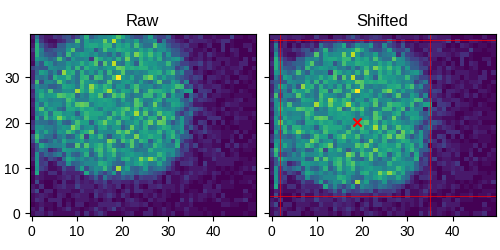

In [6]:
window = np.s_[120:160, :50]

fig, ax = plt.subplots(1,2, figsize=(5,2.5), sharex=True, sharey=True, constrained_layout=True)

im_raw   = ax[0].imshow(sxdm_raw[0][window], origin='lower')
im_shift = ax[1].imshow(sxdm_shift[0][window], origin='lower')

ax[0].set_title('Raw')
ax[1].set_title('Shifted')

ax[1].scatter(18.8, 20.2, marker='x', c='r')
ax[1].axhline(38.3, lw=0.5, c='r')
ax[1].axhline(3.9, lw=0.5, c='r')
ax[1].axvline(1.8, lw=0.5, c='r')
ax[1].axvline(35, lw=0.5, c='r')

@ipw.interact(i=(0, len(sxdm_raw)-1, 1))
def compare_raw_and_shifted(i=0):
    im_raw.set_data(sxdm_raw[i][window])
    im_shift.set_data(sxdm_shift[i][window])
    
    im_raw.set_clim(sxdm_raw[i].min(), sxdm_raw[i].max())
    im_shift.set_clim(im_raw.get_clim())
    
    fig.canvas.draw()

Generate XSOCS-compatible `h5` files with links to the raw data:

In [7]:
path_out = f'{path_exp}/analysis/data/{name_sample}_{name_dset}/'

# sxdm.utils.bliss.make_xsocs_links(path_dset, path_out, scan_nos)

Shift the data and generate a new set of (also XSOCS-compatible) files, this time with the (shifted) data physically within them:

In [8]:
# %%time

# sxdm.process.xsocs.shift_xsocs_data(path_dset, path_out, shifts)

Specify the XSOCS master file for the shifted and unshifted datasets:

In [9]:
path_master = f"{path_out}/{name_sample}_{name_dset}_master.h5"
path_master_shifted = f"{path_out}/{name_sample}_{name_dset}_master_shifted.h5"

# Transformation from angular to reciprocal space

Select a single scan to plot in q-space coordinates to check if any angular offsets need to be applied. I choose the one in the middle of the rocking curve:

In [10]:
scan_no = '30.1'

Get the sum of all the detector frames part of this SXDM scan:

In [11]:
fint = sxdm.io.bliss.get_sxdm_frame_sum(path_dset, scan_no)

In [12]:
!head /data/id01/inhouse/data_analysis/software/pyenvs/sxdm.slurm/lib/python3.8/site-packages/sxdm/io/bliss.py

import numpy as np
import multiprocessing as mp
import os
import h5py

from tqdm.notebook import tqdm
from functools import partial
from datetime import datetime

from id01lib.io.utils import ioh5


Now,
* Load some angles
* Specify angular offsets (start with 0)
* Calculate q-space coordinates 
* Compute the COM of the 104 GaN peak from the cif file
* Compute the COM for the measured scan
* Compare the two and determine the offets
* Modify offsets accordingly

In [13]:
# load nu
nu = sxdm.io.bliss.get_positioner(path_dset, scan_no, "nu")

# specify offsets
offsets = {"phi": 1.18, "nu": nu}

# compute q-space coordinates - shape is (516,516)
qx, qy, qz = id01lib.xrd.qspace.bliss.get_qspace_vals(
    path_dset,
    scan_no,
    offsets=offsets,
    ignore_mpx_motors=True,
)

# load cif file and id01 geometry in xrayutilities
print("")
mat = xu.materials.Crystal.fromCIF(f"{path_exp}/analysis/GaN.cif")
qconv = xu.QConversion(("y-", "z-"), ("y-"), (1, 0, 0))  # eta, phi, del
hxrd = xu.FourC(mat.Q(1, 0, 0), mat.Q(0, 0, 1), en=10000, qconv=qconv)  # IP, OOP

# compute COM for experimental data (NB this is InGaN not GaN)
_roi = np.s_[:, 245:]
com_exp = [
    x
    for x in sxdm.process.math.calc_com_3d(
        fint[_roi], qx[_roi], qy[_roi], qz[_roi], n_pix=500
    )
]
print("\nExp : ", [float(f"{x:.3f}") for x in com_exp])

# compute COM from cif data
com_th = hxrd.Transform(mat.Q(1, 0, 4))
print("Theo: ", [float(f"{x:.4f}") for x in com_th])

# print difference
print("\ndiff: ", [float(f"{x:.4f}") for x in com_exp - com_th])

Using cen_pix: x=115.582, y=135.194
Using det_dist = 1.22054 m
Using energy = 9.99968 keV
NOT correcting the central pixel for mpxy=0.0, mpxz=15.0
------------------
Subtracting 1.180 from phi
Subtracting -0.400 from nu

XU.materials: element N used instead of N3-

Exp :  [2.338, 0.0, 4.677]
Theo:  [2.2744, 0.0, 4.8435]

diff:  [0.0635, 0.0001, -0.1662]


Plot to check q-conversion:

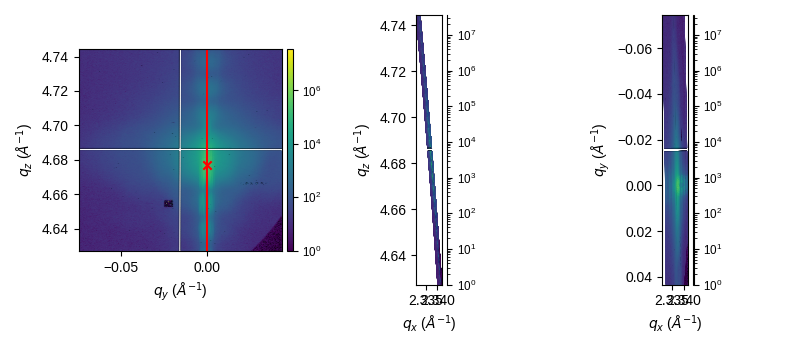

In [14]:
fig, ax = plt.subplots(1,3,figsize=(8,3.5), dpi=100)

ax[0].pcolormesh(qy, qz, fint, norm=LogNorm(), shading='gouraud')
ax[1].pcolormesh(qx, qz, fint, norm=LogNorm(), shading='gouraud')
ax[2].pcolormesh(qx, qy, fint, norm=LogNorm(), shading='gouraud')

ax[2].invert_yaxis()

[ax[i].set_ylabel(r'$q_z$ ($\AA^{-1}$)') for i in (0,1)]
[ax[i].set_xlabel(r'$q_x$ ($\AA^{-1}$)') for i in (1,2)]


ax[0].set_xlabel(r'$q_y$ ($\AA^{-1}$)')
ax[2].set_ylabel(r'$q_y$ ($\AA^{-1}$)')

ax[0].axvline(c='r')
ax[0].scatter(com_exp[1], com_exp[2], marker='x', c='r')

for a in ax:
    a.set_aspect('equal')
    sxdm.plot.add_colorbar(a, a.get_children()[0])
    
fig.tight_layout()

Compute a mask for hot and bad pixels:

Text(0.5, 1.0, 'Masked')

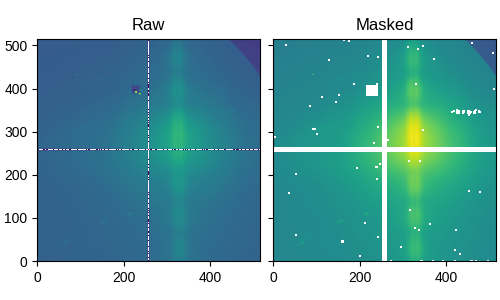

In [15]:
# sum of all frames for all scans (computed elsewhere)
fint = np.load(f'{path_exp}/analysis/totint.npy')

# mask
fmask = np.zeros_like(fint)
fmask[fint == 0] = 1
fmask[fint > 1e7] = 1
fmask[384:406, 217:241] = 1

# plot
fig, ax = plt.subplots(1,2, sharey=True, sharex=True, layout='constrained', figsize=(5,3))

ax[0].imshow(fint, norm=LogNorm())
ax[1].imshow(np.ma.masked_array(fint, mask=fmask), norm=LogNorm())

ax[0].set_title('Raw')
ax[1].set_title('Masked')

Estimate the maximum size of the q-space grid to interpolate the data onto:

In [16]:
maxbins = sxdm.process.xsocs.estimate_n_bins(path_master, offsets=offsets)
print(f'Max n of bins: {maxbins}')

Subtracting 0 from eta
Subtracting 1.18 from phi
Subtracting 0 from rx
Subtracting 0 from ry
Subtracting -0.4 from nu
Subtracting 0 from delta


Max n of bins: [66, 350, 225]


Perform the conversion to q-space for the whole (shifted) dataset:

In [17]:
path_qspace = f'{path_out}/qspace_shift_0.h5'

In [18]:
%%time

try:
    sxdm.process.xsocs.grid_qspace_xsocs(
        path_qspace,
        path_master_shifted, 
        [60,100,100],
        overwrite=False,
        offsets=offsets,
        mask=fmask,
    )
except RuntimeError:
    print('> Data exists! Set overwrite=True if needed.\n')

> Data exists! Set overwrite=True if needed.

CPU times: user 314 ms, sys: 97.9 ms, total: 411 ms
Wall time: 2.52 s


# Determination of a VOI in reciprocal space

Load q-space coordinates and compute the average rocking curve from the 5D q-space (gridded) dataset:

In [19]:
qx, qy, qz = sxdm.utils.get_qspace_coords(path_qspace)

if False:
    qspace_avg = sxdm.io.xsocs.get_qspace_avg(path_qspace, n_threads=55)
    np.save(f'{path_out}/qspace_avg.npy', qspace_avg)
    
qspace_avg = np.load(f'{path_out}/qspace_avg.npy')

Check the position of the average COM and compare it again with the theoretical 104 one taken from the cif file:

In [20]:
import xrayutilities as xu

mat = xu.materials.Crystal.fromCIF(f'{path_exp}/analysis/GaN.cif') 
qconv = xu.QConversion(('y-', 'z-'), ('y-'), (1,0,0)) # eta, phi, del
hxrd = xu.FourC(mat.Q(1,0,0), mat.Q(0,0,1), en=10000, qconv=qconv) # IP, OOP

qxx, qyy, qzz = np.meshgrid(qx, qy, qz, indexing='ij')
com_exp = [x for x in sxdm.process.math.calc_com_3d(qspace_avg, qxx, qyy, qzz, n_pix=int(5e3))]
print('\nExp : ', [float(f'{x:.3f}') for x in com_exp])

com_th = hxrd.Transform(mat.Q(1,0,4))
print('Theo: ', [float(f'{x:.3f}') for x in com_th])

print('\ndiff: ', [float(f'{x:.3f}') for x in com_exp - com_th])

XU.materials: element N used instead of N3-

Exp :  [2.338, 0.0, 4.681]
Theo:  [2.274, 0.0, 4.843]

diff:  [0.063, 0.0, -0.163]


Plot the average q-space as orthogonal projections:

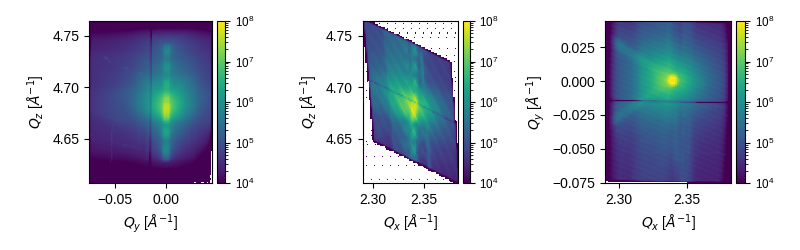

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i in range(3):
    ax[i].imshow(qspace_avg.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(1e4,1e8))
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$Q_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'$Q_y$ [$\AA^{-1}$]')

for i in (1, 2):
    ax[i].set_xlabel(r'$Q_x$ [$\AA^{-1}$]')

for i in (0, 1):
    ax[i].set_ylabel(r'$Q_z$ [$\AA^{-1}$]')

Use the widget below to determine a VOI within such average q-space volume:

IntSlider(value=50, description='depth', max=99)

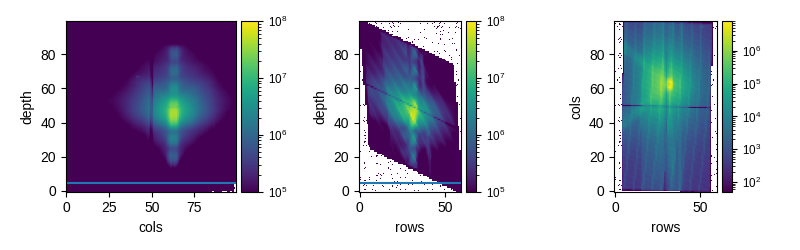

In [22]:
i0 = 50

fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

im0 = ax[0].imshow(qspace_avg.sum(0).T, norm=LogNorm(1e5,1e8))
lines0 = [ax[i].axhline(qz[i0]) for i in (0, 1)]
ax[0].set_xlabel(r'cols')
ax[0].set_ylabel(r'depth')

im1 = ax[1].imshow(qspace_avg.sum(1).T, norm=LogNorm(1e5,1e8))
ax[1].set_xlabel(r'rows')
ax[1].set_ylabel(r'depth')

imslice = ax[2].imshow(qspace_avg[..., i0].T, norm=LogNorm())
ax[2].set_xlabel(r'rows')
ax[2].set_ylabel(r'cols')

for a in ax:
    cbar = sxdm.plot.add_colorbar(a, a.get_images()[0], size='10%')

fig.subplots_adjust(bottom=.22, top=.9, left=.08, right=.98)
    
def sliceit(change):
    i0 = change['new']
    _0 = [l.set_ydata(i0) for l in lines0]
    imslice.set_data(qspace_avg[..., i0].T)

    ax[2].set_title(f'depth: {i0}')
    fig.canvas.draw()

slider = ipw.IntSlider(value=i0, min=0, max=qspace_avg.shape[-1]-1, description='depth')
slider.observe(sliceit, names='value')
slider

Specify the VOI as a mask. The mask is `True` within the VOI:

In [23]:
mask = np.zeros(qspace_avg.shape).astype('bool')
mask[3:55, 30:95, 34:68] = True # rows, cols, depth
mask = ~mask

Compute some useful quantities based on this VOI:

In [24]:
roi         = np.where(~mask) # list of VOI indexes
roi_sh      = tuple([x.max()-x.min()+1 for x in roi]) # shape of the VOI
roi_idxs    = [(x.min(), x.max()+1) for x in roi] # VOI in pixel coords
roi_slice   = tuple([slice(x.min(), x.max()+1) for x in roi]) # VOI as slices to preserve shape
roi_qcoords = [q[roi_slice] for q in np.meshgrid(qx, qy, qz, indexing='ij')] # VOI in q-coordinates

qspace_avg_masked = np.ma.masked_array(data=qspace_avg, mask=mask) # VOI via a masked array: original shape
qspace_avg_sliced = qspace_avg[roi_slice] # VOI via slicing: new shape

Display the VOI, in 3D:

In [25]:
import ipyvolume as ipv

roi_surf = []
for i, j, k in ([0,1,2], [0,2,1]):
    for m in (0,1):
        a, b = np.meshgrid(roi_idxs[i], roi_idxs[j])
        c = np.ones((2,2)) * roi_idxs[k][m]
        roi_surf.append(np.array([a,b,c])[[0,j,k]])

fig = ipv.figure()
iso = ipv.plot_isosurface(qspace_avg, level=2e4)

for r in roi_surf:
    ipv.plot_wireframe(*r, color='green')
    
ipv.xlim(0,qspace_avg.shape[0])
ipv.ylim(0,qspace_avg.shape[1])
ipv.zlim(0,qspace_avg.shape[2])

ipv.view(40, 90)
ipv.show()

And in orthogonal projections:

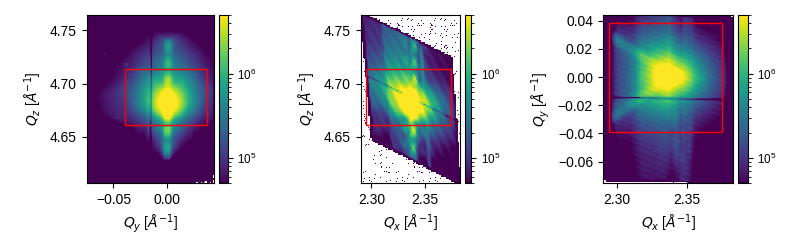

In [26]:
%matplotlib widget

from matplotlib.patches import Rectangle as R

fig, ax = plt.subplots(1, 3, figsize=(8, 2.5), layout='tight')

# draw the _roi as rectangles
_roi = [y for x in roi_qcoords for y in [x.min(), x.max()]]
r2 = R((_roi[0], _roi[2]), _roi[1]-_roi[0], _roi[3]-_roi[2],
       edgecolor='r', facecolor='none', transform=ax[2].transData)  # xy
r1 = R((_roi[0], _roi[4]), _roi[1]-_roi[0], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[1].transData)  # xz
r0 = R((_roi[2], _roi[4]), _roi[3]-_roi[2], _roi[5]-_roi[4],
       edgecolor='r', facecolor='none', transform=ax[0].transData)  # yz

_qext = sxdm.utils.get_q_extents(qx, qy, qz)
for i, r in zip(range(3), [r0, r1, r2]):
    ax[i].imshow(qspace_avg.sum(i).T, extent=_qext[i],
                 origin='lower', aspect='equal', norm=LogNorm(5e4,5e6))
    ax[i].add_patch(r)
    cbar = sxdm.plot.add_colorbar(ax[i], ax[i].get_images()[0], size='7%')

# labels etc.
ax[0].set_xlabel(r'$Q_y$ [$\AA^{-1}$]')
ax[2].set_ylabel(r'$Q_y$ [$\AA^{-1}$]')

for i in (1, 2):
    ax[i].set_xlabel(r'$Q_x$ [$\AA^{-1}$]')

for i in (0, 1):
    ax[i].set_ylabel(r'$Q_z$ [$\AA^{-1}$]')

# Calculation and visualisation of local structural parameters

## COMs 

Compute COMs within the VOI for the 5D dataset using the strongest `n_pix` pixels (`None` for all pixels):

In [27]:
cx_t, cy_t, cz_t = sxdm.process.math.calc_coms_qspace3d(path_qspace, mask, n_pix=None)

Compute the sum of the intensity falling within the VOI at all sample positions:

In [28]:
roi_int_t = sxdm.process.math.calc_roi_sum(path_qspace, mask)

Reshape and mask the computed arrays based on the shift values:

In [29]:
# load piezo coordinates
pix, piy = sxdm.io.xsocs.get_piezo_motorpos(path_master_shifted)

# (x, y) shift window and extents
pi_win = np.s_[
    int(shifts[:,0].max()):int(shifts[:,0].min()),
    int(shifts[:,1].max()):int(shifts[:,1].min())
] 
pi_ext = [pix.min(), pix.max(), piy.min(), piy.max()]

# mask based on (x, y) shift window
dmask = np.ones_like(pix)
dmask[pi_win] = 0

# make masked arrays
cx, cy, cz, roi_int = [np.ma.masked_where(
    dmask != 0, x.reshape(pix.shape)) for x in (cx_t, cy_t, cz_t, roi_int_t)]

Returning pix,piy of shape [200, 200]


Compute local structural parameters:

In [30]:
# reference q vector
cxm, cym, czm = cx.mean(), cy.mean(), cz.mean()

# local q vector and its magnitude
Q = np.array([cx, cy, cz])
q = np.sqrt(cx**2 + cy**2 + cz**2)

# average q vector and its magnitude
Q_av = np.array([cxm, cym, czm])
q_av = np.sqrt(cxm**2 + cym**2 + czm**2)

# local and average interplanar distances
d = 2 * np.pi / q
d_av = 2 * np.pi / q_av

# abosulte angle between q and Q : tilt magnitude
_numerator = np.dot(
    Q_av, Q.flatten().reshape(3, Q.shape[1]*Q.shape[2])
)
_denominator = q.flatten() * q_av
tiltmag = np.degrees(np.arccos(_numerator / _denominator))
tiltmag = tiltmag.reshape(q.shape)

# azimuthal angle between q and Q : tilt direction
az = 90 + np.degrees(np.arctan2(cx - cxm, cy - cym))

# compute tilt magnitude + direction in single HSV array
tilt = sxdm.plot.make_hsv(tiltmag, az, stretch=True)

Plot the results:

Text(0.5, 0, '$q_x$ ($\\AA^{-1}$)')

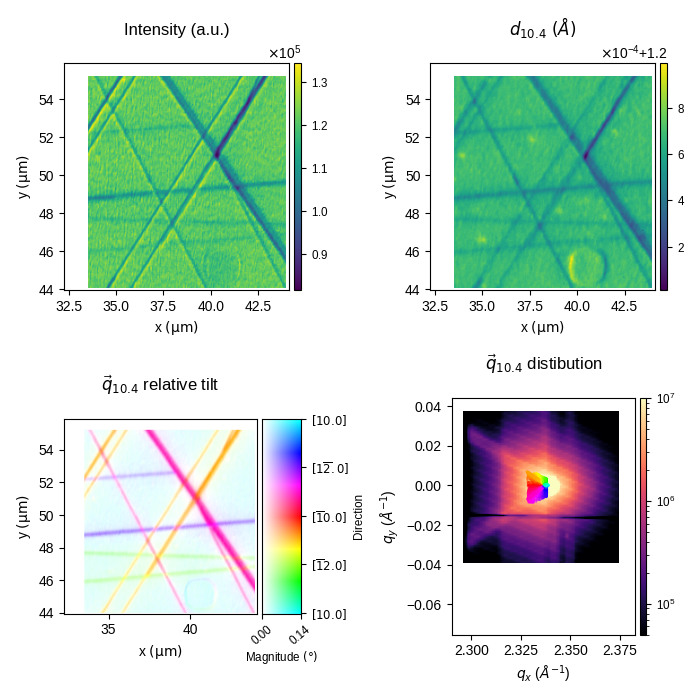

In [31]:
# rotate the result arrays to match the q-space directions
roi_int_plot, d_plot, tilt_plot = [
    np.fliplr(np.rot90(m, k=3)) for m in (roi_int, d, tilt)
]

# figure init
titles = [
    r"Intensity (a.u.)", 
    r"$d_{10.4}~(\AA)$", 
    r"$\vec{q}_{10.4}$ relative tilt", 
    r"$\vec{q}_{10.4}$ distibution"
]
fig, axs = plt.subplots(
    2,
    2,
    figsize=(7, 7),
    layout="tight",
    dpi=100,
)
ax = axs.flatten()

# plots
ax[0].imshow(roi_int_plot, extent=pi_ext, cmap="viridis")
ax[1].imshow(d_plot, extent=pi_ext, cmap="viridis")
ax[2].imshow(tilt_plot, extent=pi_ext, cmap="hsv")

_az = np.degrees(np.arctan2(cy - cym, cx - cxm))
qext = [qx.min(), qx.max(), qy.min(), qy.max()]

ax[3].imshow(
    qspace_avg_masked.sum(2).T,
    extent=qext,
    norm=LogNorm(5e4, 1e7),
    cmap="magma",
    origin="lower",
)
ax[3].scatter(
    cx, cy, marker="o", s=0.5, c=-_az, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=20)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
labels = ["$[10.0]$", "$[\overline{1}2.0]$", "$[\overline{1}0.0]$"]
labels += ["$[1\overline{2}.0]$", "$[10.0]$"]
sxdm.plot.add_hsv_colorbar(tiltmag, ax[2], labels)

# labels
_ = [a.set_xlabel("x $(\mathsf{\mu m})$") for a in ax[:3]]
_ = [a.set_ylabel("y $(\mathsf{\mu m})$") for a in ax[:3]]

ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

Inspect the results interactively.
> NB compared to the above plot the results array are *not* rotated - and therefore their dimensions are not parallel to the q-space axes. 
This is to preserve the array indexes needed to correctly interact with the figure.

Click around the selected map or use the arrow keys to move the cursor.

In [32]:
%matplotlib widget

results = {'interplanar_distance': d, 'roi_intensity': roi_int,
           'tilt': tilt, 'tilt_magnitude': tiltmag, 'tilt_azimuth': az}

viz = sxdm.widgets.xsocs.Inspect5DQspace(
    results,
    path_qspace,
    relim_int=True,
    init_idx=[50, 50],
    projections='2d',
    coms=[cx,cy,cz]
)

viz.ax[0, 0].get_images()[0].set_cmap("viridis")
viz.fig.set_figwidth(9)
viz.fig.set_figheight(8)
viz._iflog.value = True
viz.show()

## Gaussian fitting (via XSOCS) 

Compute the sum of the intensity falling within the VOI at all sample positions if not done already above:

In [33]:
roi_int_t = sxdm.process.math.calc_roi_sum(path_qspace, mask)

In [34]:
# load piezo coordinates
pix, piy = sxdm.io.xsocs.get_piezo_motorpos(path_master_shifted)

# (x, y) shift window and extents
pi_win = np.s_[
    int(shifts[:,0].max()):int(shifts[:,0].min()),
    int(shifts[:,1].max()):int(shifts[:,1].min())
] 
pi_ext = [pix.min(), pix.max(), piy.min(), piy.max()]

# mask based on (x, y) shift window
dmask = np.ones_like(pix)
dmask[pi_win] = 0

# mask array
roi_int = np.ma.masked_where(dmask != 0, roi_int_t.reshape(pix.shape))

Returning pix,piy of shape [200, 200]


Prepare the Gaussian fitting:

In [35]:
from xsocs.process.fit import PeakFitter, FitTypes, BackgroundTypes
from xsocs.io.FitH5 import FitH5

fitter = PeakFitter(
    path_qspace,
    fit_type=FitTypes.GAUSSIAN,
    n_proc=os.cpu_count(),
    roi_indices=roi_idxs,
    background=BackgroundTypes.SNIP,
)

Run the fitting and load the results:

In [36]:
%%time 
    
# Run the processing and get the results
results = fitter.peak_fit()

# Check for errors
if fitter.status != fitter.DONE:
    print("Fit process failed")
    sys.exit()

headers = ['sample_x', 'sample_y']
values = [results.sample_x, results.sample_y]

for dimension, axis_name in enumerate(results.qspace_dimension_names): # qx, qy, qz
    for parameter_name in results.available_result_names: # Area, Center, Sigma, Status
        headers.append(axis_name + '_' + parameter_name)
        values.append(results.get_results(dimension, parameter_name))

# transpose values from (parameters x points) to (points x parameters)
values = np.array(values).T

# load piezo coordinates
pix, piy = sxdm.io.xsocs.get_piezo_motorpos(path_master_shifted)

# make dict of results
res = {headers[i]:values[...,i].reshape(pix.shape) for i in range(len(headers))}

# reduce dict to only relevant data
names = [[f'q{m}_Area', f'q{m}_Center', f'q{m}_Sigma'] for m in 'x,y,z'.split(',')]
fits_gauss = {n[0].split('_')[0]:np.vstack([res[m].flatten() for m in n]).T for n in names}

# get the local q vector coordinates fromt the fits
gx, gy, gz = [np.vstack(f)[..., 1].reshape(pix.shape) for f in fits_gauss.values()]
gx, gy, gz = [np.ma.masked_where(dmask.reshape(pix.shape) != 0, g) for g in (gx, gy, gz)] 

Returning pix,piy of shape [200, 200]
CPU times: user 4.05 s, sys: 2.1 s, total: 6.15 s
Wall time: 8.87 s


Compute local structural parameters:

In [37]:
# reference q vector
gxm, gym, gzm = gx.mean(), gy.mean(), gz.mean()

# local q vector and its magnitude
Q = np.array([gx, gy, gz])
q = np.sqrt(gx**2 + gy**2 + gz**2)

# average q vector and its magnitude
Q_av = np.array([gxm, gym, gzm])
q_av = np.sqrt(gxm**2 + gym**2 + gzm**2)

# local and average interplanar distances
d = 2 * np.pi / q
d_av = 2 * np.pi / q_av

# abosulte angle between q and Q : tilt magnitude
_numerator = np.dot(
    Q_av, Q.flatten().reshape(3, Q.shape[1]*Q.shape[2])
)
_denominator = q.flatten() * q_av
tiltmag = np.degrees(np.arccos(_numerator / _denominator))
tiltmag = tiltmag.reshape(q.shape)

# azimuthal angle between q and Q : tilt direction
az = 90 + np.degrees(np.arctan2(gx - gxm, gy - gym))

# compute tilt magnitude + direction in single HSV array
tilt = sxdm.plot.make_hsv(tiltmag, az, stretch=True)

Plot:

Text(0.5, 0, '$q_x$ ($\\AA^{-1}$)')

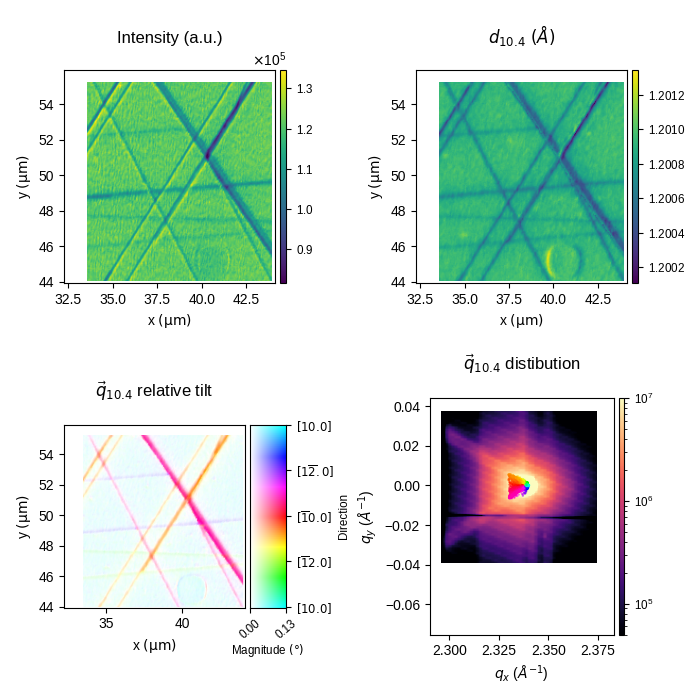

In [38]:
# rotate the result arrays to match the q-space directions
roi_int_plot, d_plot, tilt_plot = [
    np.fliplr(np.rot90(m, k=3)) for m in (roi_int, d, tilt)
]

# figure init
titles = [
    r"Intensity (a.u.)", 
    r"$d_{10.4}~(\AA)$", 
    r"$\vec{q}_{10.4}$ relative tilt", 
    r"$\vec{q}_{10.4}$ distibution"
]
fig, axs = plt.subplots(
    2,
    2,
    figsize=(7, 7),
    layout="tight",
    dpi=100,
)
ax = axs.flatten()

# plots
ax[0].imshow(roi_int_plot, extent=pi_ext, cmap="viridis")
ax[1].imshow(d_plot, extent=pi_ext, cmap="viridis")
ax[2].imshow(tilt_plot, extent=pi_ext, cmap="hsv")

_az = np.degrees(np.arctan2(gy - gym, gx - gxm))
qext = [qx.min(), qx.max(), qy.min(), qy.max()]

ax[3].imshow(
    qspace_avg_masked.sum(2).T,
    extent=qext,
    norm=LogNorm(5e4, 1e7),
    cmap="magma",
    origin="lower",
)
ax[3].scatter(
    gx, gy, marker="o", s=0.5, c=-_az, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
)

# normal colorbars
for a, t in zip(ax, titles):
    a.set_title(t, pad=20)
    if a != ax[2]:
        cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
        try:
            cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
        except:
            pass

# tilt colorbar
labels = ["$[10.0]$", "$[\overline{1}2.0]$", "$[\overline{1}0.0]$"]
labels += ["$[1\overline{2}.0]$", "$[10.0]$"]
sxdm.plot.add_hsv_colorbar(tiltmag, ax[2], labels)

# labels
_ = [a.set_xlabel("x $(\mathsf{\mu m})$") for a in ax[:3]]
_ = [a.set_ylabel("y $(\mathsf{\mu m})$") for a in ax[:3]]

ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

In [39]:
%matplotlib widget

results = {'interplanar_distance': d, 'roi_intensity': roi_int,
           'tilt': tilt, 'tilt_magnitude': tiltmag, 'tilt_azimuth': az}

viz = sxdm.widgets.xsocs.Inspect5DQspace(
    results,
    path_qspace,
    init_idx=[100, 100],
    projections='1d',
    gauss_fits=fits_gauss,
    qspace_roi=roi_slice,
    relim_int=True,
    xsocs_gauss=True,
)

viz.fig.set_figwidth(10)
viz.fig.set_figheight(8.5)
viz.show()

## Gaussian fitting (sxdm)

For the moment this is much slower than the XSOCS version (~2 min), but supports multi-peak fitting and selection of peak profiles other than Gaussians. However only one peak is always detected by the peak-finding algorithm, so playing with the function parameters may be necessary. In addition, it is not at all obvious wether in certain locations (the dislocations) it is appropriate to think of the diffraction profiles as a sum of multiple peaks.

In [40]:
# roi_int_t = sxdm.process.math.calc_roi_sum(path_qspace, mask)

In [41]:
# from skimage import filters

# # (x, y) shift window and extents
# pi_win = np.s_[
#     int(shifts[:,0].max()):int(shifts[:,0].min()),
#     int(shifts[:,1].max()):int(shifts[:,1].min())
# ] 
# pi_ext = [pix.min(), pix.max(), piy.min(), piy.max()]

# # mask based on (x, y) shift window
# dmask = np.ones_like(pix)
# dmask[pi_win] = 0

# # make masked arrays
# roi_int = np.ma.masked_where(dmask.reshape(pix.shape) != 0, roi_int_t.reshape(pix.shape)) 

In [42]:
# %time fits_gauss = sxdm.process.math.gauss_fit(path_qspace, mask, dir_mask=dmask.astype('bool'))

In [43]:
# np.save('fits_gauss_104.npy', fits_gauss)
# fits_gauss = np.load('fits_gauss_104.npy', allow_pickle=True)[()]

In [44]:
# gx, gy, gz = [np.vstack(f)[..., 1].reshape(pix.shape) for f in fits_gauss.values()]
# gx, gy, gz = [np.ma.masked_where(dmask.reshape(pix.shape) != 0, g) for g in (gx, gy, gz)] 

In [45]:
# # origin
# # gxm, gym, gzm = 0,0,1 
# gxm, gym, gzm = gx.mean(), gy.mean(), gz.mean()

# # local Q vector and its magnitude
# Q = np.array([gx, gy, gz])
# q = np.sqrt(gx**2 + gy**2 + gz**2)

# # average q vector and its magnitude
# Q_av = np.array([gxm, gym, gzm])
# q_av = np.sqrt(gxm**2 + gym**2 + gzm**2)

# # local and average interplanar distances
# d = 2 * np.pi / q
# d_av = 2 * np.pi / q_av

# # abosulte angle between q and Q : tilt magnitude
# _numerator = np.dot(
#     Q_av, Q.flatten().reshape(3, Q.shape[1]*Q.shape[2])
# )
# _denominator = q.flatten() * q_av
# tiltmag = np.degrees(np.arccos(_numerator / _denominator))
# tiltmag = tiltmag.reshape(q.shape)

# # azimuthal angle between q and Q : tilt direction
# az = 90 + np.degrees(np.arctan2(gx - gxm, gy - gym))

# # compute tilt magnitude + direction in single HSV array
# tilt = sxdm.plot.make_hsv(tiltmag, az, stretch=True)

In [46]:
# # rotate the result arrays to match the q-space directions
# roi_int_plot, d_plot, tilt_plot = [
#     np.fliplr(np.rot90(m, k=3)) for m in (roi_int, d, tilt)
# ]

# # figure init
# titles = [
#     r"Intensity (a.u.)", 
#     r"$d_{10.4}~(\AA)$", 
#     r"$\vec{q}_{10.4}$ relative tilt", 
#     r"$\vec{q}_{10.4}$ distibution"
# ]
# fig, axs = plt.subplots(
#     2,
#     2,
#     figsize=(7, 7),
#     layout="tight",
#     dpi=100,
# )
# ax = axs.flatten()

# # plots
# ax[0].imshow(roi_int_plot, extent=pi_ext, cmap="viridis")
# ax[1].imshow(d_plot, extent=pi_ext, cmap="viridis")
# ax[2].imshow(tilt_plot, extent=pi_ext, cmap="hsv")

# _az = np.degrees(np.arctan2(gy - gym, gx - gxm))
# qext = [qx.min(), qx.max(), qy.min(), qy.max()]

# ax[3].imshow(
#     qspace_avg_masked.sum(2).T,
#     extent=qext,
#     norm=LogNorm(5e4, 1e7),
#     cmap="magma",
#     origin="lower",
# )
# ax[3].scatter(
#     gx, gy, marker="o", s=0.5, c=-_az, cmap="hsv", alpha=0.5, vmin=-180, vmax=180
# )

# # normal colorbars
# for a, t in zip(ax, titles):
#     a.set_title(t, pad=20)
#     if a != ax[2]:
#         cbar = sxdm.plot.add_colorbar(a, a.get_images()[0])
#         try:
#             cbar.ax.ticklabel_format(scilimits=(0, 0), useMathText=True)
#         except:
#             pass

# # tilt colorbar
# labels = ["$[10.0]$", "$[\overline{1}2.0]$", "$[\overline{1}0.0]$"]
# labels += ["$[1\overline{2}.0]$", "$[10.0]$"]
# sxdm.plot.add_hsv_colorbar(tiltmag, ax[2], labels)

# # labels
# _ = [a.set_xlabel("x $(\mathsf{\mu m})$") for a in ax[:3]]
# _ = [a.set_ylabel("y $(\mathsf{\mu m})$") for a in ax[:3]]

# ax[3].set_ylabel(r"$q_y$ ($\AA^{-1}$)")
# ax[3].set_xlabel(r"$q_x$ ($\AA^{-1}$)")

In [47]:
# %matplotlib widget

# results = {'interplanar_distance': d, 'roi_intensity': roi_int,
#            'tilt': tilt, 'tilt_magnitude': tiltmag, 'tilt_azimuth': az}

# viz = sxdm.widgets.xsocs.Inspect5DQspace(
#     results,
#     path_qspace,
#     relim_int=True,
#     init_idx=[100, 100],
#     projections='1d',
#     gauss_fits=fits_gauss,
# )

# viz.ax[0, 0].get_images()[0].set_cmap("viridis")
# viz.fig.set_figwidth(10)
# viz.fig.set_figheight(7)
# viz._iflog.value = False
# viz.show()

# Export data

In [48]:
# !rm res_104.h5

In [49]:
# with h5py.File('res_104.h5', 'a') as h5f:
    
#     # COM goup
#     if 'COM' not in h5f.keys():
#         coms = h5f.create_group('COM')
#     else:
#         coms = h5f['COM']
        
#     # com
#     for c, n in zip((cx, cy, cz), 'cx,cy,cz'.split(',')):
#         if n not in coms.keys():
#             coms.create_dataset(n, data=c)
#         else:
#             coms[n][...] = c
            
#     # Gauss goup
#     if 'Gauss' not in h5f.keys():
#         gauss = h5f.create_group('Gauss')
#     else:
#         gauss = h5f['Gauss']
        
#     # com
#     for n in fits_gauss.keys():
#         if f'g{n[1]}' not in gauss:
#             gauss.create_dataset(f'g{n[1]}', data=np.vstack(fits_gauss[n])) # area, pos, fwhm
#         else:
#             gauss[f'g{n[1]}'][...] = np.vstack(fits_gauss[n])

#     #  intensity
#     if 'roi_int' not in h5f.keys():
#         h5f.create_dataset('roi_int', data=roi_int)
#     else:
#         h5f['roi_int'][...] = roi_int
    
#     # window
#     if 'pi_win' not in h5f:
#         h5f.create_dataset('pi_win', data=str(pi_win))

In [50]:
# h5p('res_104.h5')